## Setting the environment

In [1]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")
sns.set_palette("dark")
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

## Loading dataset

In [2]:
df = pd.read_csv("D:\\Portfolio\\03_IMDB_reviews\\IMDB_Preprocessed.csv")
df.head()

,Unnamed: 0,sentiment,text_clean
0,0,1,one reviewers mentioned watching 1 oz episode ...
1,1,1,wonderful little production br br filming tech...
2,2,1,thought wonderful way spend time hot summer we...
3,3,0,basically family little boy jake thinks zombie...
4,4,1,petter mattei love time money visually stunnin...


In [3]:
# Dataset exploration
df.shape

(49582, 3)

In [4]:
# Checking for missing values
df.isnull().values.any()

False

<AxesSubplot:xlabel='sentiment', ylabel='count'>

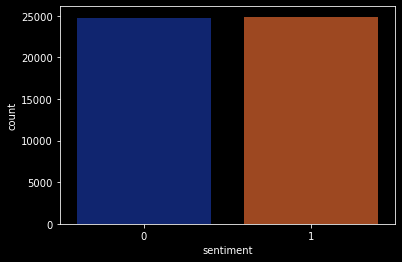

In [5]:
# Let's observe distribution of positive / negative sentiments in dataset
import seaborn as sns
sns.countplot(x='sentiment', data=df)

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

<AxesSubplot:xlabel='sentiment', ylabel='count'>

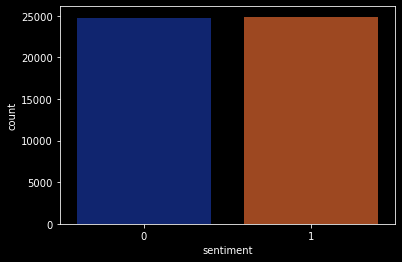

In [7]:
import seaborn as sns
sns.countplot(x='sentiment', data=df)

In [8]:
# Drop rows with missing values in the 'text_clean' column
df.dropna(subset=['text_clean'], inplace=True)

In [9]:
df.shape

(49582, 3)

In [10]:
# Seperating input and output
X = df['text_clean'].tolist()  # Convert 'text_clean' column to a list of sentences
y = df['sentiment']

In [107]:
# # Convert 'Star_Rating' column to integers (assuming it represents class labels)
# y = y.astype(int)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [12]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form
from keras.preprocessing.text import Tokenizer

# Convert 'text_clean' column to strings
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

# Create the Tokenizer and fit on the training data
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

# Convert sentences to numeric sequences
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length (required for input to neural networks)
max_sequence_length = max(len(seq) for seq in X_train + X_test)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [13]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92996

In [14]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('D:\\Portfolio\\03_IMDB_reviews\\a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [16]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
embedding_matrix.shape

(92996, 100)

# Model Training with:

## Simple Neural Network

In [28]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())

snn_model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
Dropout(0.3),

snn_model.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
Dropout(0.3),

snn_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
Dropout(0.3),

snn_model.add(Dense(1, kernel_initializer='normal'))

In [29]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(snn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9299600   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               1280128   
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,590,097
Trainable params: 1,290,497
N

In [30]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
248/248 [==============================] - 8s 27ms/step - loss: 0.6202 - accuracy: 0.6837 - val_loss: 0.5433 - val_accuracy: 0.7377
Epoch 2/6
248/248 [==============================] - 6s 26ms/step - loss: 0.6113 - accuracy: 0.6993 - val_loss: 0.5920 - val_accuracy: 0.6786
Epoch 3/6
248/248 [==============================] - 6s 26ms/step - loss: 0.6232 - accuracy: 0.7303 - val_loss: 0.5399 - val_accuracy: 0.7387
Epoch 4/6
248/248 [==============================] - 7s 29ms/step - loss: 0.5276 - accuracy: 0.7635 - val_loss: 0.5600 - val_accuracy: 0.7431
Epoch 5/6
248/248 [==============================] - 7s 27ms/step - loss: 0.4774 - accuracy: 0.7900 - val_loss: 0.5510 - val_accuracy: 0.7410
Epoch 6/6
248/248 [==============================] - 7s 27ms/step - loss: 0.4568 - accuracy: 0.8017 - val_loss: 0.6408 - val_accuracy: 0.7580


In [55]:
#Making Predictions
pred_train_snn_model = snn_model.predict(X_train)
y_pred_snn_model=snn_model.predict(X_test)
# Making predictions in binary format
pred_train_binary = (pred_train_snn_model > 0.5).astype(int)
y_pred_binary = (y_pred_snn_model > 0.5).astype(int)

print(confusion_matrix(y_test,y_pred_binary))
print(classification_report(y_test,y_pred_binary))
print("***Accuracy score***")
print("Train Accuracy score for snn_model is ",accuracy_score(y_train, pred_train_binary))
print("Test Accuracy score for snn_model is ",accuracy_score(y_test, y_pred_binary))
print("***Recall score***")
print("Train recall score for snn_model is ",recall_score(y_train, pred_train_binary))
print("Test recall score for snn_model is ",recall_score(y_test, y_pred_binary))

310/310 [==============================] - 1s 4ms/step
[[3576 1363]
 [1102 3876]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      4939
           1       0.74      0.78      0.76      4978

    accuracy                           0.75      9917
   macro avg       0.75      0.75      0.75      9917
weighted avg       0.75      0.75      0.75      9917

***Accuracy score***
Train Accuracy score for snn_model is  0.8154292197151141
Test Accuracy score for snn_model is  0.7514369264898659
***Recall score***
Train recall score for snn_model is  0.8348739073646136
Test recall score for snn_model is  0.7786259541984732


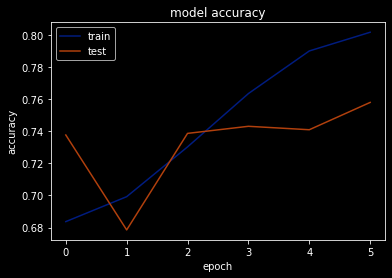

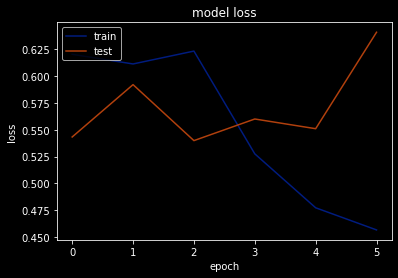

In [32]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['accuracy'])
plt.plot(snn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [33]:
from keras.layers import Conv1D

In [39]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [40]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          9299600   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 64)            32064     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,331,729
Trainable params: 32,129
Non-trainable params: 9,299,600
_________________________________________________________________
None


In [41]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
248/248 [==============================] - 11s 42ms/step - loss: 0.4952 - acc: 0.7566 - val_loss: 0.3957 - val_acc: 0.8219
Epoch 2/6
248/248 [==============================] - 10s 40ms/step - loss: 0.3599 - acc: 0.8445 - val_loss: 0.3749 - val_acc: 0.8284
Epoch 3/6
248/248 [==============================] - 10s 40ms/step - loss: 0.3091 - acc: 0.8715 - val_loss: 0.3466 - val_acc: 0.8473
Epoch 4/6
248/248 [==============================] - 10s 41ms/step - loss: 0.2731 - acc: 0.8915 - val_loss: 0.3408 - val_acc: 0.8505
Epoch 5/6
248/248 [==============================] - 11s 43ms/step - loss: 0.2418 - acc: 0.9079 - val_loss: 0.3403 - val_acc: 0.8518
Epoch 6/6
248/248 [==============================] - 10s 39ms/step - loss: 0.2167 - acc: 0.9192 - val_loss: 0.3409 - val_acc: 0.8516


In [54]:
#Making Predictions
pred_train_cnn_model = cnn_model.predict(X_train)
y_pred_cnn_model=cnn_model.predict(X_test)
# Making predictions in binary format
pred_train_binary = (pred_train_cnn_model > 0.5).astype(int)
y_pred_binary = (y_pred_cnn_model > 0.5).astype(int)

print(confusion_matrix(y_test,y_pred_binary))
print(classification_report(y_test,y_pred_binary))
print("***Accuracy score***")
print("Train Accuracy score for cnn_model is ",accuracy_score(y_train, pred_train_binary))
print("Test Accuracy score for cnn_model is ",accuracy_score(y_test, y_pred_binary))
print("***Recall score***")
print("Train recall score for cnn_model is ",recall_score(y_train, pred_train_binary))
print("Test recall score for cnn_model is ",recall_score(y_test, y_pred_binary))

310/310 [==============================] - 1s 5ms/step
[[4323  616]
 [ 878 4100]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      4939
           1       0.87      0.82      0.85      4978

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917

***Accuracy score***
Train Accuracy score for cnn_model is  0.9236858691541662
Test Accuracy score for cnn_model is  0.8493496016940607
***Recall score***
Train recall score for cnn_model is  0.8997789611172511
Test recall score for cnn_model is  0.8236239453595822


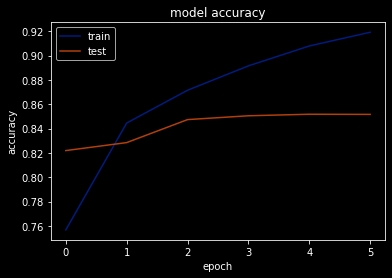

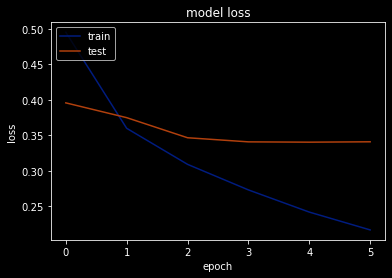

In [42]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [44]:
from keras.layers import LSTM

In [58]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))
lstm_model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))
lstm_model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1))
lstm_model.add(Dense(1, activation='sigmoid'))

In [59]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          9299600   
                                                                 
 lstm_6 (LSTM)               (None, 100, 128)          117248    
                                                                 
 lstm_7 (LSTM)               (None, 100, 64)           49408     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,478,705
Trainable params: 179,105
Non-trainable params: 9,299,600
_________________________________________________________________
None


In [60]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
248/248 [==============================] - 477s 2s/step - loss: 0.5084 - acc: 0.7512 - val_loss: 0.4476 - val_acc: 0.7931
Epoch 2/20
248/248 [==============================] - 525s 2s/step - loss: 0.4081 - acc: 0.8167 - val_loss: 0.3711 - val_acc: 0.8349
Epoch 3/20
248/248 [==============================] - 509s 2s/step - loss: 0.3568 - acc: 0.8457 - val_loss: 0.3502 - val_acc: 0.8510
Epoch 4/20
248/248 [==============================] - 496s 2s/step - loss: 0.3251 - acc: 0.8600 - val_loss: 0.3307 - val_acc: 0.8582
Epoch 5/20
248/248 [==============================] - 480s 2s/step - loss: 0.3004 - acc: 0.8744 - val_loss: 0.3047 - val_acc: 0.8709
Epoch 6/20
248/248 [==============================] - 500s 2s/step - loss: 0.2813 - acc: 0.8837 - val_loss: 0.3404 - val_acc: 0.8686
Epoch 7/20
248/248 [==============================] - 484s 2s/step - loss: 0.2708 - acc: 0.8862 - val_loss: 0.3107 - val_acc: 0.8787
Epoch 8/20
248/248 [==============================] - 474s 2s/step - 

In [61]:
#Making Predictions
pred_train_lstm_model = lstm_model.predict(X_train)
y_pred_lstm_model=lstm_model.predict(X_test)
# Making predictions in binary format
pred_train_binary = (pred_train_lstm_model > 0.5).astype(int)
y_pred_binary = (y_pred_lstm_model > 0.5).astype(int)

print(confusion_matrix(y_test,y_pred_binary))
print(classification_report(y_test,y_pred_binary))
print("***Accuracy score***")
print("Train Accuracy score for lstm_model is ",accuracy_score(y_train, pred_train_binary))
print("Test Accuracy score for lstm_model is ",accuracy_score(y_test, y_pred_binary))
print("***Recall score***")
print("Train recall score for lstm_model is ",recall_score(y_train, pred_train_binary))
print("Test recall score for lstm_model is ",recall_score(y_test, y_pred_binary))

310/310 [==============================] - 31s 99ms/step
[[4272  667]
 [ 697 4281]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4939
           1       0.87      0.86      0.86      4978

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917

***Accuracy score***
Train Accuracy score for lstm_model is  0.960721038699105
Test Accuracy score for lstm_model is  0.8624584047595039
***Recall score***
Train recall score for lstm_model is  0.9573495428514016
Test recall score for lstm_model is  0.859983929288871


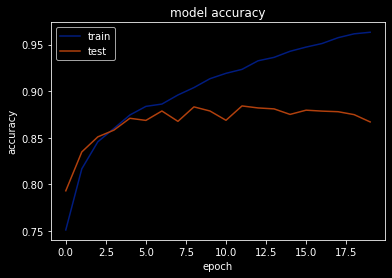

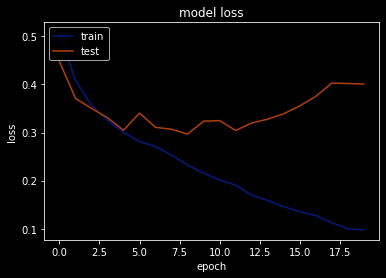

In [62]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()